# Proyecto: Árbol de decisión para predicción de diabetes

En este notebook vamos a construir varios **árboles de decisión** para predecir
si una persona tiene diabetes (`Outcome` = 1) o no (`Outcome` = 0) utilizando
el dataset `internal-link(6).csv`.

Además de un árbol básico, veremos:

- Análisis del balance de clases
- Árbol simple vs árbol complejo (sobreajuste)
- Función de métricas `get_metrics` (Train vs Test) como en clase
- Matriz de confusión
- Importancia de variables
- Visualización del árbol
- (PLUS) Búsqueda de mejores hiperparámetros con `GridSearchCV`




## Índice

1. Carga de librerías y datos  
2. Exploración inicial del dataset  
3. Análisis del balance de clases (Outcome)  
4. Visualización de variables por clase  
5. Preparación de X e y  
6. División en train y test  
7. Definición de función de métricas `get_metrics` (Train vs Test)  
8. Árbol simple (controlado)  
9. Árbol complejo (posible sobreajuste)  
10. Comparación de métricas Árbol simple vs complejo  
11. Matriz de confusión del modelo elegido  
12. Importancia de variables  
13. Visualización del árbol  
14. (PLUS) Búsqueda de hiperparámetros con GridSearchCV  
15. Conclusiones



In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    classification_report
)

# OJO: ya NO importamos imblearn aquí

sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (10, 6)



In [2]:

# 2. Carga de datos

# Ajusta la ruta si lo tienes en otra carpeta
df = pd.read_csv("../data/raw/internal-link(6).csv")

df.head()



,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [3]:
# Información general del dataframe

print("Dimensiones:", df.shape)
print("\nTipos de datos:")
print(df.dtypes)

print("\nDescripción estadística:")
df.describe()



Dimensiones: (768, 9)

Tipos de datos:
Pregnancies                   int64
Glucose                       int64
BloodPressure                 int64
SkinThickness                 int64
Insulin                       int64
BMI                         float64
DiabetesPedigreeFunction    float64
Age                           int64
Outcome                       int64
dtype: object

Descripción estadística:


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


### Variables del dataset

- **Pregnancies**: número de embarazos
- **Glucose**: concentración de glucosa en sangre
- **BloodPressure**: presión arterial diastólica
- **SkinThickness**: grosor del pliegue cutáneo del tríceps
- **Insulin**: insulina sérica
- **BMI**: índice de masa corporal
- **DiabetesPedigreeFunction**: indicador de historial familiar de diabetes
- **Age**: edad
- **Outcome**: variable objetivo (0 = no diabetes, 1 = diabetes)


Recuento de clases:
Outcome
0    500
1    268
Name: count, dtype: int64

Proporciones de clases:
Outcome
0    0.651042
1    0.348958
Name: proportion, dtype: float64


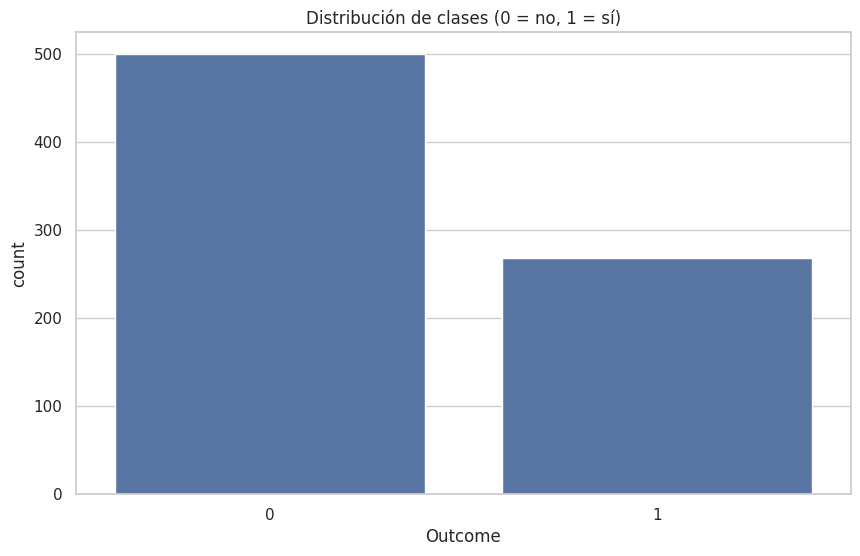

In [4]:
# 3. Análisis del balance de clases

print("Recuento de clases:")
print(df["Outcome"].value_counts())

print("\nProporciones de clases:")
print(df["Outcome"].value_counts(normalize=True))

sns.countplot(x="Outcome", data=df)
plt.title("Distribución de clases (0 = no, 1 = sí)")
plt.show()


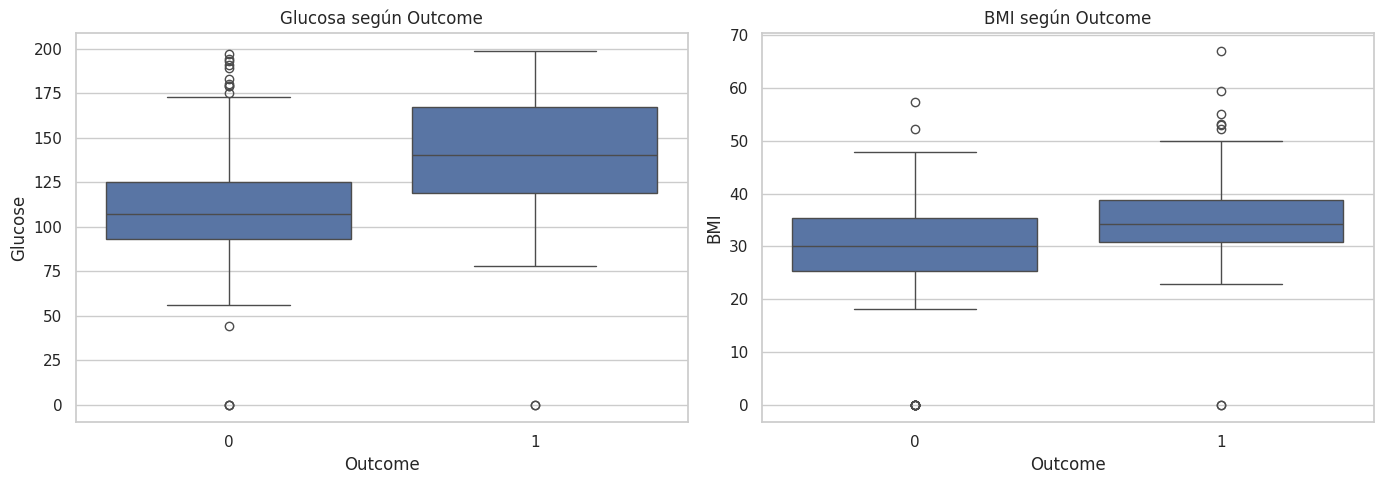

In [5]:
# 4. Visualización de algunas variables por clase

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

sns.boxplot(x="Outcome", y="Glucose", data=df, ax=axes[0])
axes[0].set_title("Glucosa según Outcome")

sns.boxplot(x="Outcome", y="BMI", data=df, ax=axes[1])
axes[1].set_title("BMI según Outcome")

plt.tight_layout()
plt.show()


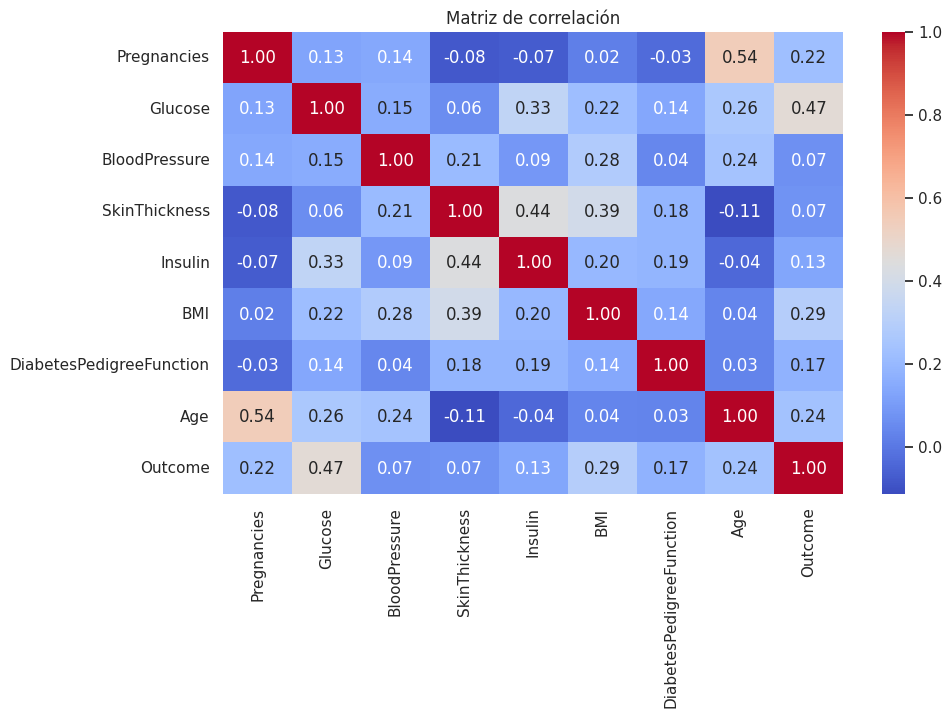

In [6]:
# Matriz de correlación entre variables numéricas

corr = df.corr()

sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Matriz de correlación")
plt.show()


In [7]:
# 5. Preparación de X (features) e y (target)

X = df.drop("Outcome", axis=1)
y = df["Outcome"]

X.head()


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
0,6,148,72,35,0,33.6,0.627,50
1,1,85,66,29,0,26.6,0.351,31
2,8,183,64,0,0,23.3,0.672,32
3,1,89,66,23,94,28.1,0.167,21
4,0,137,40,35,168,43.1,2.288,33


In [8]:
# 6. División en entrenamiento y test

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y   # mantiene proporción de 0 y 1 en train y test
)

print("Tamaño X_train:", X_train.shape)
print("Tamaño X_test:", X_test.shape)


Tamaño X_train: (614, 8)
Tamaño X_test: (154, 8)


In [9]:
# 7. Definición de función de métricas Train vs Test


def get_metrics(y_train, y_test, y_pred_train, y_pred_test):
    """
    Calcula métricas de clasificación para train y test
    (accuracy, precision, recall, especificidad y F1).
    """

    def specificity(y_true, y_pred):
        # calculamos la matriz de confusión
        cm = confusion_matrix(y_true, y_pred)
        TN = cm[0, 0]
        FP = cm[0, 1]
        return TN / (TN + FP) if (TN + FP) > 0 else 0

    metrics = {
        "accuracy": [
            accuracy_score(y_train, y_pred_train),
            accuracy_score(y_test, y_pred_test)
        ],
        "precision": [
            precision_score(y_train, y_pred_train, zero_division=0),
            precision_score(y_test, y_pred_test, zero_division=0)
        ],
        "recall (sensibilidad)": [
            recall_score(y_train, y_pred_train),
            recall_score(y_test, y_pred_test)
        ],
        "especificidad": [
            specificity(y_train, y_pred_train),
            specificity(y_test, y_pred_test)
        ],
        "f1": [
            f1_score(y_train, y_pred_train),
            f1_score(y_test, y_pred_test)
        ]
    }

    metrics_df = pd.DataFrame(metrics, index=["Train", "Test"])
    metrics_df["diferencia"] = metrics_df.loc["Train"] - metrics_df.loc["Test"]
    return metrics_df

In [10]:
# 8. Árbol simple (profundidad limitada)

simple_tree = DecisionTreeClassifier(
    max_depth=3,       # árbol poco profundo
    random_state=42
)

simple_tree.fit(X_train, y_train)

y_pred_train_simple = simple_tree.predict(X_train)
y_pred_test_simple = simple_tree.predict(X_test)

print("MÉTRICAS ÁRBOL SIMPLE")
get_metrics(y_train, y_test, y_pred_train_simple, y_pred_test_simple)


MÉTRICAS ÁRBOL SIMPLE


,accuracy,precision,recall (sensibilidad),especificidad,f1,diferencia
Train,0.767101,0.873684,0.387850,0.97,0.537217,NaN
Test,0.694805,0.666667,0.259259,0.93,0.373333,NaN


In [11]:
# 9. Árbol complejo (sin limitar profundidad → tiende a sobreajustar)

complex_tree = DecisionTreeClassifier(
    random_state=42  # sin max_depth
)

complex_tree.fit(X_train, y_train)

y_pred_train_complex = complex_tree.predict(X_train)
y_pred_test_complex = complex_tree.predict(X_test)

print("MÉTRICAS ÁRBOL COMPLEJO")
get_metrics(y_train, y_test, y_pred_train_complex, y_pred_test_complex)


MÉTRICAS ÁRBOL COMPLEJO


,accuracy,precision,recall (sensibilidad),especificidad,f1,diferencia
Train,1.000000,1.000000,1.0,1.00,1.0000,NaN
Test,0.727273,0.642857,0.5,0.85,0.5625,NaN


In [12]:
metrics_simple = get_metrics(y_train, y_test, y_pred_train_simple, y_pred_test_simple)
metrics_complex = get_metrics(y_train, y_test, y_pred_train_complex, y_pred_test_complex)

print("ÁRBOL SIMPLE")
display(metrics_simple)

print("\nÁRBOL COMPLEJO")
display(metrics_complex)


ÁRBOL SIMPLE


,accuracy,precision,recall (sensibilidad),especificidad,f1,diferencia
Train,0.767101,0.873684,0.387850,0.97,0.537217,NaN
Test,0.694805,0.666667,0.259259,0.93,0.373333,NaN



ÁRBOL COMPLEJO


,accuracy,precision,recall (sensibilidad),especificidad,f1,diferencia
Train,1.000000,1.000000,1.0,1.00,1.0000,NaN
Test,0.727273,0.642857,0.5,0.85,0.5625,NaN


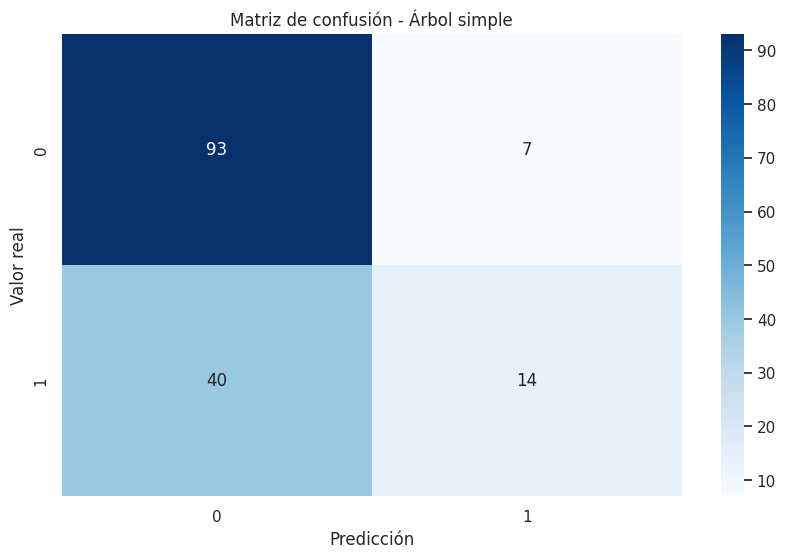

Classification report:
              precision    recall  f1-score   support

           0       0.70      0.93      0.80       100
           1       0.67      0.26      0.37        54

    accuracy                           0.69       154
   macro avg       0.68      0.59      0.59       154
weighted avg       0.69      0.69      0.65       154



In [13]:
# 11. Matriz de confusión del modelo elegido (árbol simple)

y_pred_final = y_pred_test_simple  # árbol simple

cm = confusion_matrix(y_test, y_pred_final)

sns.heatmap(cm, annot=True, fmt="g", cmap="Blues")
plt.xlabel("Predicción")
plt.ylabel("Valor real")
plt.title("Matriz de confusión - Árbol simple")
plt.show()

print("Classification report:")
print(classification_report(y_test, y_pred_final))


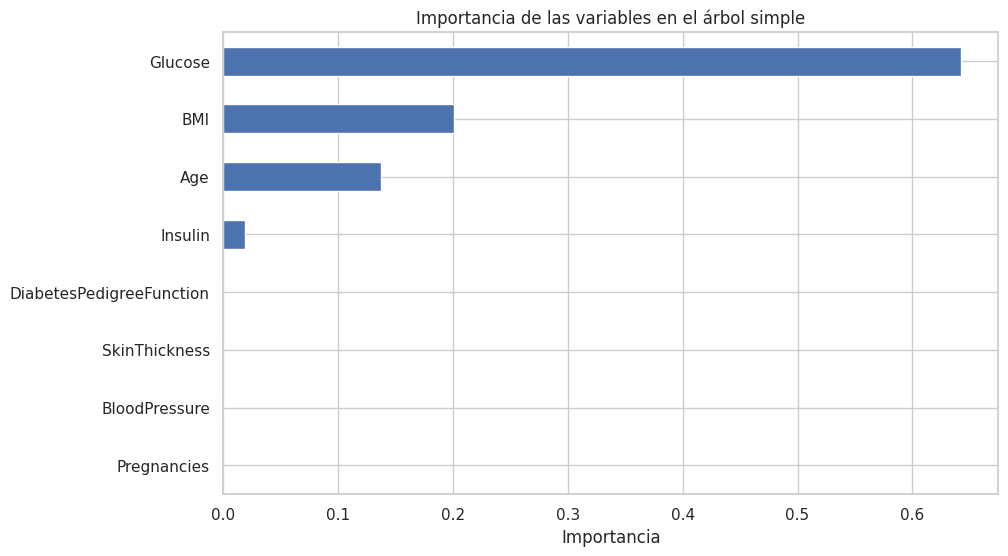

In [14]:
# 12. Importancia de variables

importances = pd.Series(simple_tree.feature_importances_, index=X.columns)

importances.sort_values().plot(kind="barh")
plt.title("Importancia de las variables en el árbol simple")
plt.xlabel("Importancia")
plt.show()


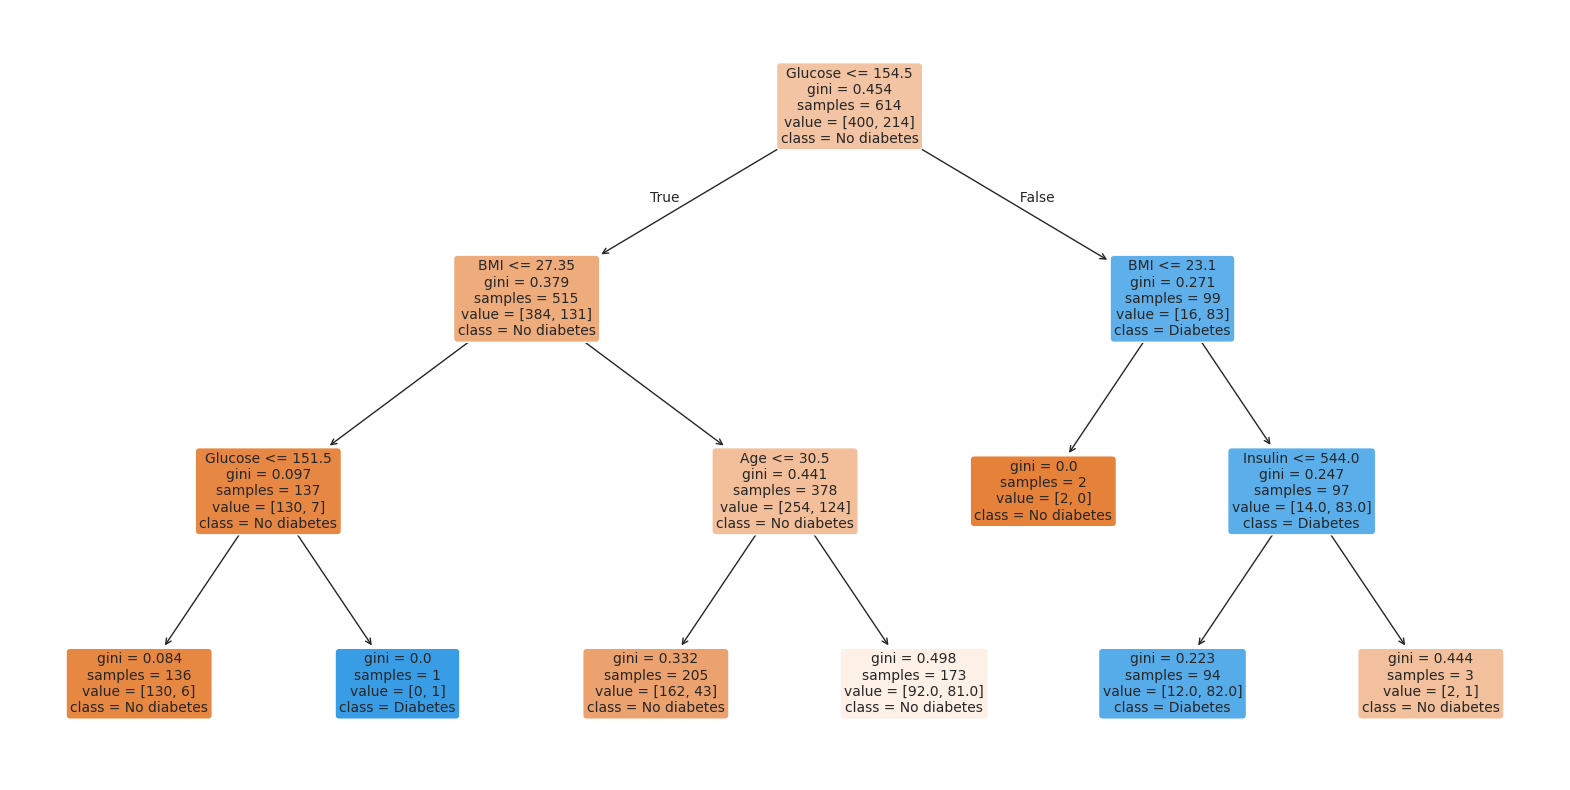

In [15]:
# 13. Visualización del árbol de decisión simple

plt.figure(figsize=(20, 10))
plot_tree(
    simple_tree,
    feature_names=X.columns,
    class_names=["No diabetes", "Diabetes"],
    filled=True,
    rounded=True,
    fontsize=10
)
plt.show()


In [16]:
# 14. (PLUS) Búsqueda de mejores hiperparámetros con GridSearchCV

param_grid = {
    "max_depth": [2, 3, 4, 5, None],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4]
}

grid_search = GridSearchCV(
    estimator=DecisionTreeClassifier(random_state=42),
    param_grid=param_grid,
    scoring="f1",   # optimizamos F1 porque el problema es sanitario
    cv=5,
    n_jobs=-1
)

grid_search.fit(X_train, y_train)

print("Mejores hiperparámetros encontrados:")
print(grid_search.best_params_)

print("\nMejor puntuación media de F1 en validación cruzada:")
print(grid_search.best_score_)


Mejores hiperparámetros encontrados:
{'max_depth': 4, 'min_samples_leaf': 1, 'min_samples_split': 2}

Mejor puntuación media de F1 en validación cruzada:
0.5698724844702964


In [17]:
# Entrenamos un modelo final con los mejores hiperparámetros

best_tree = grid_search.best_estimator_

y_pred_train_best = best_tree.predict(X_train)
y_pred_test_best = best_tree.predict(X_test)

print("MÉTRICAS ÁRBOL OPTIMIZADO (GridSearch)")
get_metrics(y_train, y_test, y_pred_train_best, y_pred_test_best)


MÉTRICAS ÁRBOL OPTIMIZADO (GridSearch)


,accuracy,precision,recall (sensibilidad),especificidad,f1,diferencia
Train,0.796417,0.723618,0.672897,0.8625,0.697337,NaN
Test,0.798701,0.744681,0.648148,0.8800,0.693069,NaN


# 15. Conclusiones

- El dataset de diabetes contiene variables clínicas que permiten predecir
  razonablemente bien el diagnóstico (Outcome).
- El análisis del balance de clases muestra [comentar proporciones que hayas visto].
- Los árboles de decisión permiten generar reglas interpretables. Un **árbol simple**
  (con `max_depth` pequeña) generaliza mejor que un árbol muy profundo.
- La función `get_metrics` permite comparar el rendimiento en **Train vs Test**
  y detectar sobreajuste (igual que en la clase del profesor).
- La matriz de confusión y el `classification_report` muestran el rendimiento
  detallado (precision, recall, f1) para cada clase.
- Las variables más importantes en el modelo suelen ser **Glucose**, **BMI** y **Age**,
  lo cual tiene sentido clínico.
- Con `GridSearchCV` hemos ajustado los hiperparámetros del árbol y obtenido
  un modelo optimizado que mejora el equilibrio entre sensibilidad y especificidad.

En conjunto, el proyecto reproduce la estructura vista en clase, añade análisis
extra (importancia de variables, GridSearch) y aplica el modelo a un problema
real de salud: la predicción de diabetes.
